In [ ]:
%reset

### DOWNLOAD DATA

In [ ]:
import os
import requests

CENSUS = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)
def dl_data(path='cencus_data', urls=CENSUS):
    if not os.path.exists(path):
        os.mkdir(path)
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)
            
dl_data()

### LOAD AND INITIAL CLEANING

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education_num",
        "marital_status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital_gain",
        "capital_loss",
        "hours_per_week",
        "native_country",
        "income",  
]

df_train = pd.read_csv('cencus_data/adult.data', names=names)
df_test  = pd.read_csv('cencus_data/adult.test', names=names, skiprows=1)

adult = pd.concat([df_train,df_test])
adult.replace(' ?', np.nan, inplace=True)
# adult.dropna()
adult.replace(to_replace=r'\.',value=r'', regex=True, inplace=True)
adult.replace(to_replace=r' ',value=r'', regex=True, inplace=True)
adult.reset_index(inplace = True, drop = True)

adult['income'] = adult.income.replace(['<=50K', '>50K'], [0, 1]).astype(np.int64)
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education_num     48842 non-null int64
marital_status    48842 non-null object
occupation        46033 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital_gain      48842 non-null int64
capital_loss      48842 non-null int64
hours_per_week    48842 non-null int64
native_country    47985 non-null object
income            48842 non-null int64
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [2]:
adult.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### CHNAGE DATA TYPE

In [3]:
# adult['income'] = adult['income'].astype('int64')
adult[adult.select_dtypes('object').columns]= adult.select_dtypes('object').apply(lambda x:x.astype('category'))
# for col in adult.columns:
#     if adult[col].dtype !='int64':
#         adult[col] = adult[col].apply(lambda val: val.replace(" ", ""))

In [4]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age               48842 non-null int64
workclass         46043 non-null category
fnlwgt            48842 non-null int64
education         48842 non-null category
education_num     48842 non-null int64
marital_status    48842 non-null category
occupation        46033 non-null category
relationship      48842 non-null category
race              48842 non-null category
sex               48842 non-null category
capital_gain      48842 non-null int64
capital_loss      48842 non-null int64
hours_per_week    48842 non-null int64
native_country    47985 non-null category
income            48842 non-null int64
dtypes: category(8), int64(7)
memory usage: 3.0 MB


In [5]:
adult.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

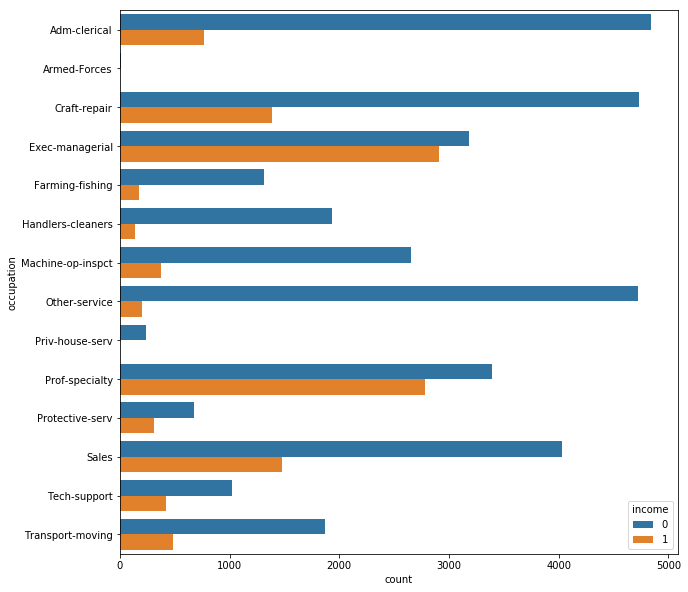

In [6]:
fig=plt.figure(figsize=(10,10))
sns.countplot(y='occupation',hue='income', data=adult)

### MISSING VALUES

In [7]:
def missing_values(data):
    for i,j in list(zip(data.columns, (data.isnull().sum()))):
        if j>1:
            print (f"{i}: missing {j}")
        
missing_values(adult)        


workclass: missing 2799
occupation: missing 2809
native_country: missing 857


In [8]:
col_name = ['workclass','occupation','native_country']
for col in col_name:
    print (f"******************{col}******************")
    print (adult[col].value_counts(dropna=False))

******************workclass******************
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
NaN                  2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64
******************occupation******************
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
NaN                  2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64
******************native_country******************
United-States                 43832
Mexico                          951
NaN                             857
Philippines                     295
Germany                    

### PREDICTING MISSING VALUES WITH KNN

In [9]:
#prediciting "workclass" missing values with KNN

miss_test_X = adult[adult['workclass'].isna()].copy()
miss_test_Y = miss_test_X.workclass
miss_test_X.drop(columns = ['workclass'], inplace = True)

miss_train_X  = adult[adult['workclass'].notna()].copy()
miss_train_Y = miss_train_X.workclass
miss_train_X.drop(columns = ['workclass'], inplace = True)

def HotEncoding (data,data_cat):
    df_1 = data.drop(columns = data_cat.select_dtypes('category').columns, axis=1)
    df_2 = pd.get_dummies(data[data_cat.select_dtypes('category').columns])
    return pd.concat([df_1, df_2], axis=1)
        
miss_test_data = HotEncoding(miss_test_X,miss_test_X)
miss_train_data = HotEncoding(miss_train_X,miss_train_X)

from sklearn.neighbors import KNeighborsClassifier

knn_miss = KNeighborsClassifier(n_neighbors=5)
knn_miss.fit(miss_train_data, miss_train_Y)
knn_pred = knn_miss.predict(miss_test_data)

adult.loc[adult['workclass'].isna(),['workclass']] = knn_pred

In [10]:
#prediciting "occupation" missing values with KNN

miss_test_X = adult[adult['occupation'].isna()].copy()
miss_test_Y = miss_test_X.occupation
miss_test_X.drop(columns = ['occupation'], inplace = True)

miss_train_X  = adult[adult['occupation'].notna()].copy()
miss_train_Y = miss_train_X.occupation
miss_train_X.drop(columns = ['occupation'], inplace = True)

def HotEncoding (data,data_cat):
    df_1 = data.drop(columns = data_cat.select_dtypes('category').columns, axis=1)
    df_2 = pd.get_dummies(data[data_cat.select_dtypes('category').columns])
    return pd.concat([df_1, df_2], axis=1)
        
miss_test_data = HotEncoding(miss_test_X,miss_test_X)
miss_train_data = HotEncoding(miss_train_X,miss_train_X)

from sklearn.neighbors import KNeighborsClassifier

knn_miss = KNeighborsClassifier(n_neighbors=5)
knn_miss.fit(miss_train_data, miss_train_Y)
knn_pred = knn_miss.predict(miss_test_data)

adult.loc[adult['occupation'].isna(),['occupation']] = knn_pred

In [11]:
#prediciting "native_country" missing values with KNN

miss_test_X = adult[adult['native_country'].isna()].copy()
miss_test_Y = miss_test_X.native_country
miss_test_X.drop(columns = ['native_country'], inplace = True)

miss_train_X  = adult[adult['native_country'].notna()].copy()
miss_train_Y = miss_train_X.native_country
miss_train_X.drop(columns = ['native_country'], inplace = True)

def HotEncoding (data,data_cat):
    df_1 = data.drop(columns = data_cat.select_dtypes('category').columns, axis=1)
    df_2 = pd.get_dummies(data[data_cat.select_dtypes('category').columns])
    return pd.concat([df_1, df_2], axis=1)
        
miss_test_data = HotEncoding(miss_test_X,miss_test_X)
miss_train_data = HotEncoding(miss_train_X,miss_train_X)

from sklearn.neighbors import KNeighborsClassifier

knn_miss = KNeighborsClassifier(n_neighbors=5)
knn_miss.fit(miss_train_data, miss_train_Y)
knn_pred = knn_miss.predict(miss_test_data)

adult.loc[adult['native_country'].isna(),['native_country']] = knn_pred      


In [12]:
adult['workclass'].value_counts()

Private             36558
Self-emp-not-inc     3900
Local-gov            3197
State-gov            1987
Self-emp-inc         1707
Federal-gov          1462
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

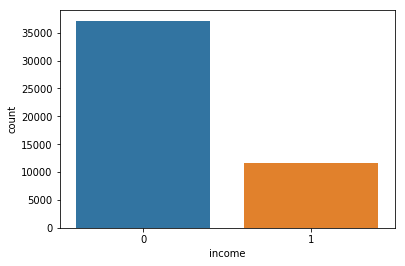

In [13]:
sns.countplot(x='income',data=adult)

### HEATMAP FOR SHOWING CORRELATIONS

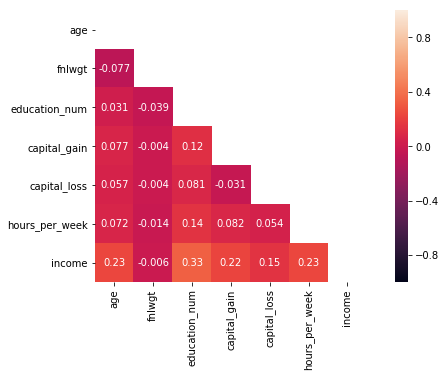

In [14]:
corr = adult.corr().round(3)
plt.figure(figsize=(10,5))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr, mask=mask, vmin = -1, vmax = 1, annot=True, square=True)
## Almost No correlations b/w features

### Model preparation

In [15]:
### Model preparation
print (f"before {adult.shape}")
col_del =['relationship','education_num']
adult.drop(columns = col_del, inplace=True, axis=1)

print (f"after {adult.shape}")


before (48842, 15)
after (48842, 13)


##### MARITAL STATUS

In [16]:
adult.marital_status.unique()

[Never-married, Married-civ-spouse, Divorced, Married-spouse-absent, Separated, Married-AF-spouse, Widowed]
Categories (7, object): [Never-married, Married-civ-spouse, Divorced, Married-spouse-absent, Separated, Married-AF-spouse, Widowed]

In [17]:
married = ['Married-civ-spouse', 'Married-spouse-absent','Married-AF-spouse']
separted = ['Separated','Divorced']

adult['marital_status'].replace(to_replace=married, value='Married', inplace=True)
adult['marital_status'].replace(to_replace=separted, value='Separated', inplace=True)

adult.marital_status.value_counts()

Married          23044
Never-married    16117
Separated         8163
Widowed           1518
Name: marital_status, dtype: int64

##### EDUCATION

In [18]:
hs_grad = ['HS-grad','11th','10th','9th','12th']
elementary = ['1st-4th','5th-6th','7th-8th']

adult['education'].replace(to_replace = hs_grad,value = 'HS-grad',inplace = True)
adult['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)

adult.education.unique()

array(['Bachelors', 'HS-grad', 'Masters', 'Some-college', 'Assoc-acdm',
       'Assoc-voc', 'elementary_school', 'Doctorate', 'Prof-school',
       'Preschool'], dtype=object)

##### WORKCLASS

In [19]:
self_employed = ['Self-emp-not-inc','Self-emp-inc']
govt_employees = ['Local-gov','State-gov','Federal-gov']

adult['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
adult['workclass'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

adult.workclass.unique()

array(['Govt_employees', 'Self_employed', 'Private', 'Without-pay',
       'Never-worked'], dtype=object)

### PREPROCESSING AND MODEL SELECTION

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#apply scaler to num columns

num_cols = adult.select_dtypes('int64')
cat_cols = adult.select_dtypes(exclude='int64')
#cat_cols = ['workclass', 'education', 'marital_status', 'occupation', 'race', 'sex', 'native_country']
train_X = adult.drop(columns = ['income'])

In [21]:
train_X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'marital_status',
       'occupation', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country'],
      dtype='object')

In [22]:
cat_cols.head()

,workclass,education,marital_status,occupation,race,sex,native_country
0,Govt_employees,Bachelors,Never-married,Adm-clerical,White,Male,United-States
1,Self_employed,Bachelors,Married,Exec-managerial,White,Male,United-States
2,Private,HS-grad,Separated,Handlers-cleaners,White,Male,United-States
3,Private,HS-grad,Married,Handlers-cleaners,Black,Male,United-States
4,Private,Bachelors,Married,Prof-specialty,Black,Female,Cuba


In [23]:
train_X = pd.get_dummies(train_X)
X =  pd.concat([train_X, num_cols],axis=1, join='inner')
X = X.drop(columns = 'income')
y =  adult['income']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# y_train = y_train.replace(['<=50K', '>50K'], [0, 1])
# y_test = y_test.replace(['<=50K', '>50K'], [0, 1])

pd.DataFrame(y_train).head()



C:\Users\arman\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\arman\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\arman\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """


,income
46447,0
9116,0
16797,1
45574,1
39901,0


### MACHINE LEARNING PART

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc

import warnings
import time
import datetime
warnings.filterwarnings('ignore')



In [52]:
clf_knn = KNeighborsClassifier()
clf_log = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_SVC = SVC ()
clf_forest = RandomForestClassifier()

# models = {'Logistic Regressions': clf_log}

models = {'Logistic Regressions': clf_log, 'Decision Tree' : clf_tree,
         'Random Forest' : clf_forest, 'SVC' : clf_SVC, 'KNN' : clf_knn
         }

def training (name,algo,X_train, X_test, y_train, y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    print (f"***************************{name}***************************")
    print (f"accuracy score is {accuracy_score(y_test,y_pred)}")
    return y_test, y_pred

def result (y_test, y_pred):
    print ("Confusion Matrix")
    cm=confusion_matrix(y_test, y_pred)
    print (cm) 
    TP=cm[1,1]
    TN=cm[0,0]
    FP=cm[0,1]
    FN=cm[1,0]
    accuracy = 100*((TN+TP)/ (TP+TN+FP+FN))
    f1_score =  100*((2*TP) / (2*TP + FP + FN))
    precision = 100*((TP) / (TP+FP))
    recall = 100*((TP) / (TP+FN))
    print (f"Accuracy is: {accuracy:.4f}%\nF1 score is: {f1_score:.4f}%\nPrecision is: {precision:.4f}%\nRecall is: {recall:.4f}%")
    return accuracy

def main (models):
    acc_score = {}
#     names = []
    for name,algo in models.items(): 
        start_time = time.time()
        y_test_train,y_pred = training (name,algo,X_train, X_test, y_train, y_test)
#         acc_score.update = name,result(y_test_train,y_pred)
        acc_score[name]=(result(y_test_train,y_pred))
#         names.append(name)
        print (f"Elapsed time: {datetime.timedelta(seconds=time.time()-start_time)} ")
    return acc_score
        

accuracy_scores = main (models)
    

***************************Logistic Regressions***************************
accuracy score is 0.8510359511915486
Confusion Matrix
[[8737  657]
 [1162 1655]]
Accuracy is: 85.1036%
F1 score is: 64.5350%
Precision is: 71.5830%
Recall is: 58.7504%
Elapsed time: 0:00:01.636617 
***************************Decision Tree***************************
accuracy score is 0.8154123331422488
Confusion Matrix
[[8251 1143]
 [1111 1706]]
Accuracy is: 81.5412%
F1 score is: 60.2188%
Precision is: 59.8807%
Recall is: 60.5609%
Elapsed time: 0:00:00.555547 
***************************Random Forest***************************
accuracy score is 0.8484153631971173
Confusion Matrix
[[8798  596]
 [1255 1562]]
Accuracy is: 84.8415%
F1 score is: 62.7940%
Precision is: 72.3818%
Recall is: 55.4491%
Elapsed time: 0:00:00.585435 
***************************SVC***************************
accuracy score is 0.853165178937024
Confusion Matrix
[[8831  563]
 [1230 1587]]
Accuracy is: 85.3165%
F1 score is: 63.9018%
Precision is:

In [53]:
accuracy_scores

{'Logistic Regressions': 85.10359511915486,
 'Decision Tree': 81.54123331422488,
 'Random Forest': 84.84153631971174,
 'SVC': 85.31651789370241,
 'KNN': 82.31922037507165}

In [54]:
pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=["Accuracy Score %"]).sort_values(by=["Accuracy Score %"], ascending=False)

,Accuracy Score %
SVC,85.316518
Logistic Regressions,85.103595
Random Forest,84.841536
KNN,82.319220
Decision Tree,81.541233


### 10 FOLD CROSS VALIDATION

In [56]:

cv_scores = {}
scoring = 'accuracy'

for name , algo in models.items():
    start_time = time.time()
#     Kfold = KFold(n_splits = 10)
    cv = cross_val_score(algo, X_train, y_train, cv=10, scoring = scoring,n_jobs=-1)
#     print (f"Accuracy score is {np.mean(cv)}")
    cv_scores[name] = np.round(100*np.mean(cv),decimals=3)
    print (f"{name} Elapsed time: {datetime.timedelta(seconds=time.time()-start_time)} ")

cv_scores

Logistic Regressions Elapsed time: 0:00:13.989861 
Decision Tree Elapsed time: 0:00:02.388110 
Random Forest Elapsed time: 0:00:02.050381 
SVC Elapsed time: 0:04:15.385044 
KNN Elapsed time: 0:01:40.034771 


{'Logistic Regressions': 84.742,
 'Decision Tree': 81.349,
 'Random Forest': 84.688,
 'SVC': 84.63,
 'KNN': 81.726}

In [57]:
Acc_CV = pd.DataFrame.from_dict(cv_scores, orient='index', columns=["Accuracy Score %"]).sort_values(by=["Accuracy Score %"], ascending=False)
Acc_CV

,Accuracy Score %
Logistic Regressions,84.742
Random Forest,84.688
SVC,84.630
KNN,81.726
Decision Tree,81.349


### HYPERTUNNING

In [58]:
#hypertunning
models = {'Logistic Regressions': clf_log, 'Decision Tree' : clf_tree, 'Random Forest' : clf_forest, 'SVC' : clf_SVC, 'KNN' : clf_knn}

## Logistic Regressions
param_log = {'C': np.logspace(-4, 4, 15), 
             'penalty': ['l1','l2']
            }

## Decision Tree

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param_tree = {'criterion' : ['gini','entropy'],
              'max_depth' : max_depth,
#               'min_samples_leaf':np.arange(1,50,2),
              'min_samples_split':np.linspace(0.01,1,num=10)
              }

## Random Forest
param_forest = {'criterion' : ['gini','entropy'],
                'max_depth': max_depth,
#                 'max_features': ['auto', 'sqrt', 'log2'],
                'n_estimators':np.arange(200,700,100)
               }
## SVC
param_SVC = {'kernel': ('linear', 'rbf','poly'),
             'C':[1.5, 10],
             'gamma': [1e-7, 1e-4,1e-3]
            }

## KNN
param_knn = {'n_neighbors':np.arange(2,50,2),
            "weights": ("uniform", "distance")
            }


def hyper (model,parameter):
    start_time = time.time()
    grid = GridSearchCV(estimator=model, param_grid = parameter, cv=10, n_jobs=-1)
    grid.fit(X_train,y_train),
    print(f"************* {model} *************")
    print (f"Elapsed time: {datetime.timedelta(seconds=time.time()-start_time)} ")
    print (f"Best Score: {grid.best_score_:.4f}\nBest Parameters: {grid.best_params_}")
    
hyper (clf_tree, param_tree)

************* DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') *************
Elapsed time: 0:03:03.329981 
Best Score: 0.8561
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 0.01}
